# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# Шаг 1. Открытие данных

In [1]:
import pandas as pd 
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep="\t")
pd.options.display.max_columns = None
pd.options.display.max_rows = None


df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


### Вывод
Данные заполненны, мякго говоря, "грязно", пропущенные значеня в 14 столбцах, большое количество пропусков в апартаментах, балконах, высота потолков, парки рядом, водоемы рядом. Предпологаю, что большое количество пропусков связанно, с человеческим фактором ввода, следовательно, либо от не знания(не знают сколько метров потолки, или аппартаменты у них), либо от сокрытия данных

Смущают максимальные значения в стобцах количество комнат( хотя если это Питер, то это может быть бывшая коммунальная квартира), высота потолков(100 метров это слишком много), количество этажей( это Питер, в Питере точно нет жилого дома в 60 этажей) жилая площадь( 409 метров, возможно это та 19 комнатная квартира,) площадь кухни( слишком много), будем разбираться с каждым поэтапно

Также в таблице нужно поменять тип данных в столбце
первый день экспозиции с объект на дататайм

# Шаг 2. Предобработка данных
### Обработка дубликатов, замена пропусков


In [4]:
df.duplicated().sum() # проверка на дубликаты, дубликатов 0

df['balcony'] = df['balcony'].fillna(0) # заполним отсутствующие значения в балконы, заменив на 0
df['balcony'].isna().sum() # проверка, пропусков 0

0

In [5]:

df['locality_name'].isna().sum()
df['locality_name'] = df['locality_name'].fillna("Неизвестно") #  заполним отсутствующие значения на "Неизвестно", 



def replace_e(row):  # зададим функцию, меняем "ё" на "е"
    return row.replace('ё','е')
def only_name(row):
    return re.sub(r'\b[а-я]+\s*', "", row).strip() # через регулярки уберем все слова начинающиеся со строчных букв(типа деревня, поселок и тд)
df['locality_name'] = df['locality_name'].apply(replace_e).apply(only_name)

df['locality_name'].unique() # проверка результата



array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Федоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодежное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [32]:
from IPython.display import display
ceiling_medians = df.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['median', 'count']) # создаем датафрейм переменную для работы цикла
ceiling_medians.columns = ['median', 'count']
display(ceiling_medians.head())


for floor in ceiling_medians.index: # заменяем значения высоты потолков на общую медиану для отсутствующих значений этажности дома
    df.loc[(df['floors_total'].isna()) | ((df['floors_total'] == floor) & (ceiling_medians.loc[floor, 'count'] == 0)),'ceiling_height'] = df['ceiling_height'].median()

for floor in ceiling_medians.index: # медианы из сгруппированной таблицы вставляем на места пропущенных значений высоты потолков для дома соответствующей этажности
    df.loc[(df['ceiling_height'].isna()) & (df['floors_total'] == floor), 'ceiling_height'] = ceiling_medians.loc[floor, 'median']

def transfer_sign(height):# создаем функцию для ошибочного ввода данных, которая переместит запятую, поменяет потолки меньше 2,2 метров на медиану
    if height > 12:
        return height / 10
    if height < 2.2:
        return df['ceiling_height'].median()
    return height 

df['ceiling_height'] = df['ceiling_height'].apply(transfer_sign) 
df['ceiling_height'].unique()# проверка результатов


,median,count
floors_total,,
1.0,2.80,25
2.0,2.70,383
3.0,2.80,668
4.0,3.00,1200
5.0,2.55,5788


array([ 2.70000005,  2.75      ,  2.54999995,  2.5999999 ,  3.02999997,
        2.6500001 ,  2.66000009,  2.5       ,  2.67000008,  2.55999994,
        3.        ,  3.04999995,  2.79999995,  2.9000001 ,  3.20000005,
        2.6099999 ,  3.25      ,  3.45000005,  2.76999998,  2.8499999 ,
        2.6400001 ,  2.56999993,  4.1500001 ,  3.5       ,  3.29999995,
        2.71000004,  4.        ,  2.47000003,  2.73000002,  2.83999991,
        3.0999999 ,  2.33999991,  3.4000001 ,  3.05999994,  2.72000003,
        2.53999996,  2.50999999,  2.77999997,  2.75999999,  2.57999992,
        3.70000005,  2.51999998,  5.19999981,  2.86999989,  2.58999991,
        2.45000005,  3.5999999 ,  2.92000008,  3.1099999 ,  3.13000011,
        3.79999995,  3.1500001 ,  3.54999995,  3.16000009,  3.61999989,
        3.11999989,  2.52999997,  2.74000001,  2.96000004,  2.46000004,
        5.30000019,  5.        ,  2.78999996,  2.95000005,  4.05999994,
        2.94000006,  3.81999993,  3.53999996,  3.52999997,  2.82

In [7]:
df['studio'].value_counts()# посчитаем количество студий, 149 студий
df.query('kitchen_area != "NaN" and studio == True') # логично), в студии нет кухни, значит можно в во всех студиях в графе "кухня" пустые значения заменить на 0

df.loc[df.studio == True, 'kitchen_area'] = df.loc[df.studio == True, 'kitchen_area'].fillna(0) 


###   Замена типов данных

In [8]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') # поменяем формат с объект на дататайм

df['is_apartment'] = df['is_apartment'].astype('bool')

for column in ['last_price', 'total_area', 'ceiling_height', 'living_area','kitchen_area', 'floors_total']:
    df[column] = df[column].astype('float32')    # изменим в данных стобцах тип данных с флоат64 на флот32, с целью сокращения обЪема данных

df.loc[df['days_exposition'].isna(), 'days_exposition'] = df['days_exposition'].median() # заменим пропущенные значения в "количество дней размещения" на медиану 

df['last_price_1kk'] = df['last_price'] / 1000000 # для удобства переведем цены в млн. руб.
df.info() #

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
total_images            23699 non-null int64
last_price              23699 non-null float32
total_area              23699 non-null float32
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float32
floors_total            23613 non-null float32
living_area             21796 non-null float32
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21570 non-null float32
balcony                 23699 non-null float64
locality_name           23699 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_ar

### Вывод 

При обработке данных:
- Упорядочили названия населенных пунктов
- Избавились от пропусков в "потолках", также избавились от явно высоких и низких потолков, но некоторые значения остались, проверим в следующим шаге не вбросы ли это
- Избавились от пропусков в "Балконах"
- Поменяли формат "первого дня объявления" с объект на дататайм
- Поменяли формат Аппартоментов с объект на булеввый тип
- Поменяли формат 'last_price', 'total_area', 'ceiling_height', 'living_area','kitchen_area', 'floors_total' с флот 64 на флот32 с целью сокращения объема данных с 3.7 мб на 3.1мб (разница в 17%)



# Шаг 3. Посчитайте и добавьте в таблицу

In [9]:

df['price_sqrm'] = df['last_price_1kk'] / df['total_area'] # создадим столбец с ценой за кв метр в млн. руб.

df['weekday'] = df['first_day_exposition'].dt.weekday #  создадим столбцы днем недели, месяцем и годом отдельно
df['month'] = df['first_day_exposition'].dt.month#
df['year'] = df['first_day_exposition'].dt.year#

df.loc[df['floor'] == 1, 'floor_category'] = 'первый'# создадим столбец с категорией этажа(первый, последний, другой)
df.loc[df['floor'] == df['floors_total'], 'floor_category'] = 'последний'#
df.loc[df['floor_category'].isna(), 'floor_category'] = 'другой'#

df['ratio_area_living_total'] = df['living_area'] / df['total_area']# столбец отношение жилой площади к общей
df['ratio_area_kitchen_total'] = df['kitchen_area'] / df['total_area']# столбец отношение кухонной площади к общей

df.head(10) # проверка


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,last_price_1kk,price_sqrm,weekday,month,year,floor_category,ratio_area_living_total,ratio_area_kitchen_total
0,20,13000000.0,108.000000,2019-03-07,3,2.70,16.0,51.000000,8,True,False,False,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,95.0,13.000,0.120370,3,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.400002,2018-12-04,1,2.75,11.0,18.600000,1,True,False,False,11.00,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,3.350,0.082921,1,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.000000,2015-08-20,2,2.55,5.0,34.299999,4,True,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,5.196,0.092786,3,8,2015,другой,0.612500,0.148214
3,0,64900000.0,159.000000,2015-07-24,3,2.60,14.0,NaN,9,True,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,64.900,0.408176,4,7,2015,другой,NaN,NaN
4,2,10000000.0,100.000000,2018-06-19,2,3.03,14.0,32.000000,13,True,False,False,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,10.000,0.100000,1,6,2018,другой,0.320000,0.410000
5,10,2890000.0,30.400000,2018-09-10,1,2.65,12.0,14.400000,5,True,False,False,9.10,0.0,Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,2.890,0.095066,0,9,2018,другой,0.473684,0.299342
6,6,3700000.0,37.299999,2017-11-02,1,2.66,26.0,10.600000,6,True,False,False,14.40,1.0,Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,3.700,0.099196,3,11,2017,другой,0.284182,0.386059
7,5,7915000.0,71.599998,2019-04-18,2,2.75,24.0,NaN,22,True,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,95.0,7.915,0.110545,3,4,2019,другой,NaN,0.263966
8,20,2900000.0,33.160000,2018-05-23,1,2.70,27.0,15.430000,26,True,False,False,8.81,0.0,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,2.900,0.087455,2,5,2018,другой,0.465320,0.265682
9,18,5400000.0,61.000000,2017-02-26,3,2.50,9.0,43.599998,7,True,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,5.400,0.088525,6,2,2017,другой,0.714754,0.106557


# Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

In [10]:
def find_mustache(column):   # зададим функцию по поиску усов, все что вне усов является выбросами 
    describe = df[column].describe()
    box = describe[6] - describe[4]
    low_mustache = describe[4] - 1.5 * box
    up_mustache = describe[6] + 1.5 * box
    if low_mustache < describe[3]: 
        low_mustache = describe[3]
    if up_mustache > describe[7]:
        up_mustache = describe[7]
    return [low_mustache, up_mustache]


### Изучаем параметр "общая площадь"

Text(0.5, 0, 'Площадь кв.м.')

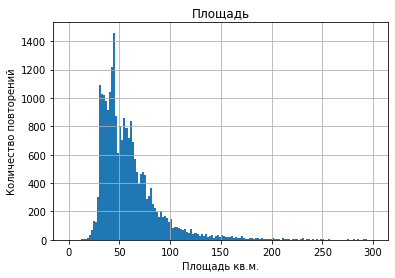

In [11]:
df['total_area'].hist(bins=150,range = (0,300))
plt.title('Площадь')
plt.ylabel('Количество повторений')
plt.xlabel('Площадь кв.м.')

Усы  [12.0, 114.75000381469727]


count    23699.000000
mean        60.348648
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900002
max        900.000000
Name: total_area, dtype: float64

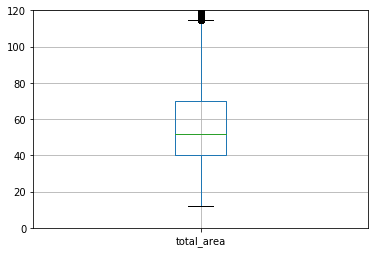

In [12]:
df.boxplot('total_area')
plt.ylim(0,120)
print('Усы ', find_mustache('total_area'))
df['total_area'].describe()


Изучаем параметр "общая площадь".
Среднее значение 52 кв. метра, аномальные значения площадь больше 114.75 кв. метров.

  

### Изучаем параметр "Цена"

Text(0.5, 0, 'Цена в млн. р.')

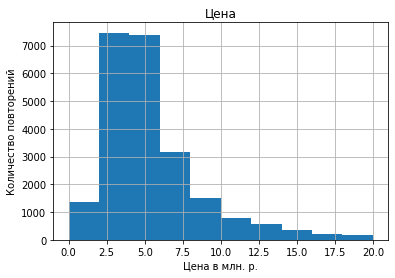

In [13]:
df['last_price_1kk'].hist(bins=10, range=(0,20))
plt.title('Цена')
plt.ylabel('Количество повторений')
plt.xlabel('Цена в млн. р.')


Усы  [0.01219, 11.899999999999999]


count    23699.000000
mean         6.541549
std         10.887013
min          0.012190
25%          3.400000
50%          4.650000
75%          6.800000
max        763.000000
Name: last_price_1kk, dtype: float64

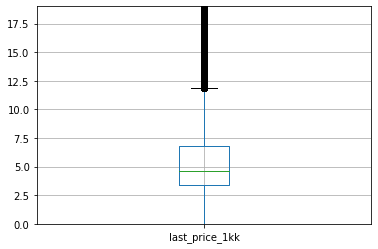

In [14]:
df.boxplot('last_price_1kk')
plt.ylim(0,19)
print('Усы ', find_mustache('last_price_1kk'))
df['last_price_1kk'].describe()

Изучаем параметр "Цена".
Средняя цена 4,65 млн. рублей, аномальные значения цена выше 11.9 млн. рублей


### Изучаем параметр "Количество комнат"

Text(0.5, 0, 'Количество комнат')

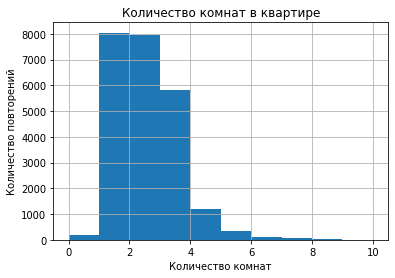

In [15]:
df['rooms'].hist(bins=10,range = (0,10))
plt.title('Количество комнат в квартире')
plt.ylabel('Количество повторений')
plt.xlabel('Количество комнат')

Усы  [0.0, 6.0]


count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

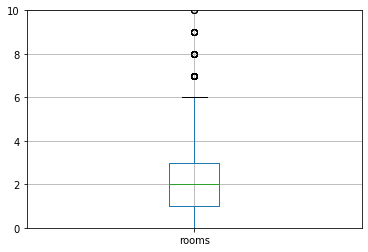

In [16]:
df.boxplot('rooms')
plt.ylim(0,10)
print('Усы ', find_mustache('rooms'))
df['rooms'].describe()

Изучаем параметр "Количество комнат"
Среднее значение 2 комнаты, анамальное значение больше 6ти комнат

### Изучаем параметр "Высота потолков"

Text(0.5, 0, 'Высота потолков в метрах')

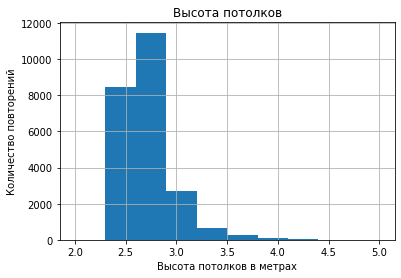

In [17]:
df['ceiling_height'].hist(bins=10,range = (2,5))
plt.title('Высота потолков')
plt.ylabel('Количество повторений')
plt.xlabel('Высота потолков в метрах')

Усы  [2.2499998807907104, 3.0500000715255737]


count    23699.000000
mean         2.709338
std          0.254135
min          1.400000
25%          2.550000
50%          2.650000
75%          2.750000
max         10.300000
Name: ceiling_height, dtype: float64

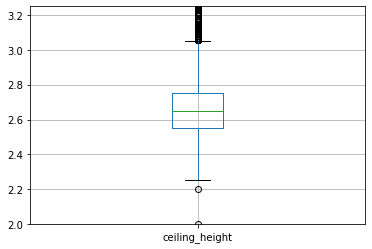

In [18]:
df.boxplot('ceiling_height')
plt.ylim(2,3.25)
print('Усы ', find_mustache('ceiling_height'))
df['ceiling_height'].describe()

Изучаем параметр "Высота потолков"
Среднее значение 2.65 метров,  аномальные значения потолки меньше 2, 25 метров и выше 3, 05 метров

Text(0.5, 0, 'Количество дней')

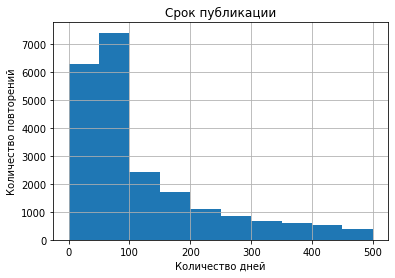

In [19]:
df['days_exposition'].hist(bins=10,range = (0,500))
plt.title('Срок публикации')
plt.ylabel('Количество повторений')
plt.xlabel('Количество дней')

### Изучаем параметр "Срок публикации"

Усы  [1.0, 430.0]


count    23699.000000
mean       169.360226
std        206.535633
min          1.000000
25%         45.000000
50%         95.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

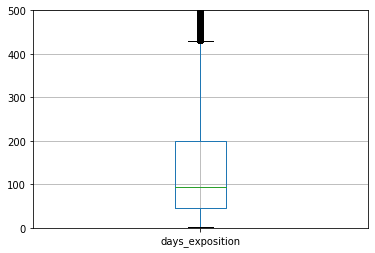

In [20]:
df.boxplot('days_exposition')
plt.ylim(0,500)
print('Усы ', find_mustache('days_exposition'))
df['days_exposition'].describe()

Изучаем параметр "Срок публикации" 
Среднее значение 95 дней, аномальные значения срок больше 430 дней

### Исследуем зависимость цены  от параметров 

                total_area  last_price_1kk     rooms  ceiling_height
total_area        1.000000        0.681016  0.802468        0.170250
last_price_1kk    0.681016        1.000000  0.418487        0.292003
rooms             0.802468        0.418487  1.000000       -0.057387
ceiling_height    0.170250        0.292003 -0.057387        1.000000


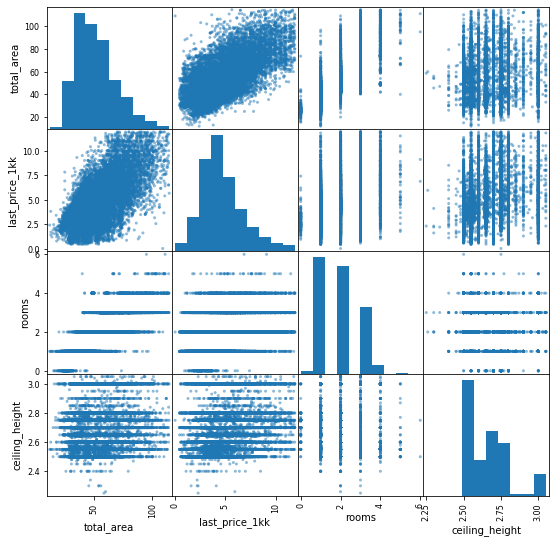

In [21]:
#  Создадим таблицу без анамальных значений 
good_df = df.query('total_area <= 114.75 & last_price_1kk <= 11.9 & rooms <= 6 & ceiling_height <= 3.05 & ceiling_height >= 2.25 & days_exposition <= 430').reset_index(drop=True)
good_df.head(10)

new_good_df = good_df.loc[:,['total_area','last_price_1kk','rooms','ceiling_height']]  
#Таблица для корреляции результатов


pd.plotting.scatter_matrix(new_good_df, figsize=(9,9))
print(new_good_df.corr())


Факторы влияющие на цену(в порядке убывания): Площадь(самый высокий коофецент корреляции 0,68), количество комнат(коофицент0,41), высота потолков ( слабый коофицент 0,29)

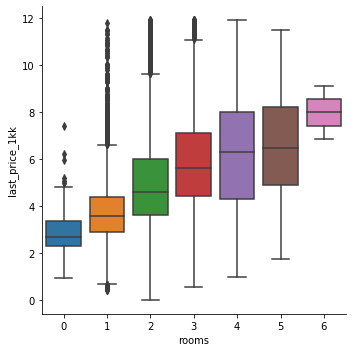

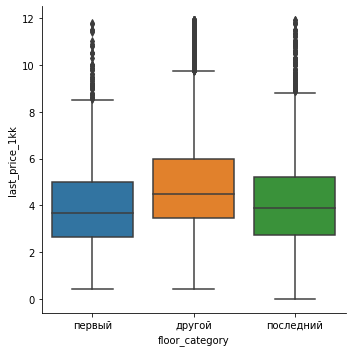

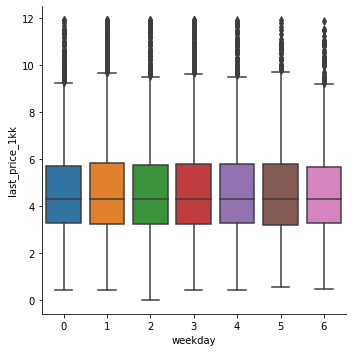

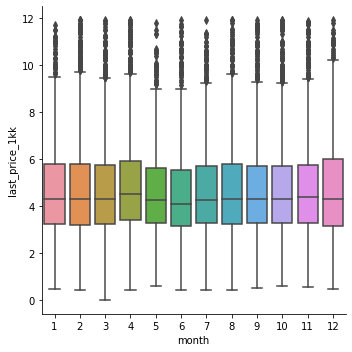

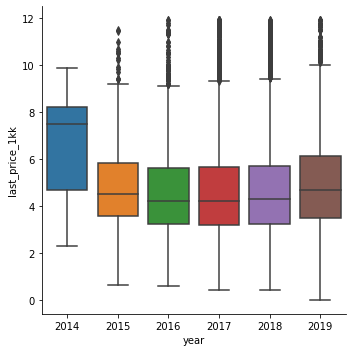

In [22]:
for column in ['rooms', 'floor_category', 'weekday', 'month', 'year']: 
    # создадим цикл построения графиков распределения по значениям, в котором пройдемся по параметрам: 
    # комнаты, категория этажей, день недели продажи,месяц продажи и год продажи
    sns.catplot(x=column, y="last_price_1kk", kind="box", data=good_df)

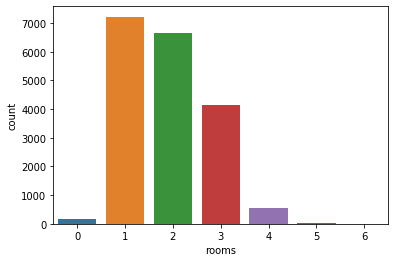

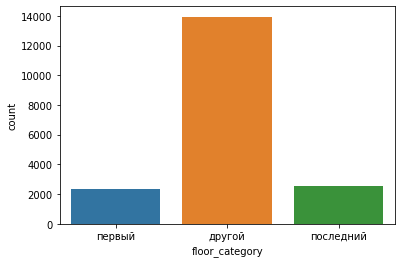

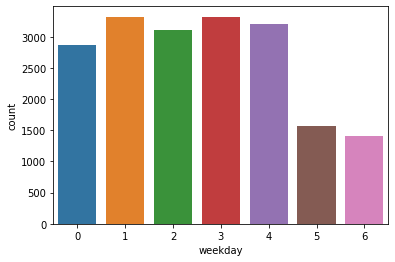

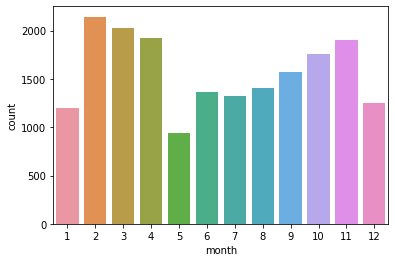

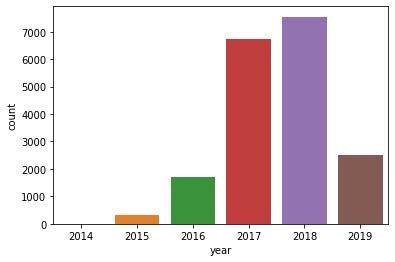

In [23]:
df_cat = good_df.loc[:,['rooms', 'floor_category', 'weekday', 'month', 'year']] # 

for column in df_cat:   # создадим цикл построения графиков для посмотра количества продаж от по категориям параметров 'rooms', 'floor_category', 'weekday', 'month', 'year' 
    sns.countplot(x=column,data=df_cat)
    plt.show()

Коофецент корреляции равен -0.31


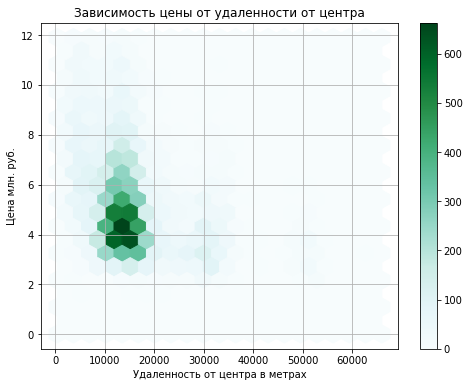

In [24]:
df_nearest_centers = good_df.query('cityCenters_nearest != "NaN"').reset_index(drop=True) # таблица с известным расстоянием до центра 

kc1 = round(good_df['last_price_1kk'].corr(good_df['cityCenters_nearest']),2) # коофицент корреляции цены от удаленности от центра

df_nearest_centers.plot(y="last_price_1kk", x="cityCenters_nearest",kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True)#kind='scatter',alpha=0.03)
plt.title('Зависимость цены от удаленности от центра')
plt.ylabel('Цена млн. руб.')
plt.xlabel('Удаленность от центра в метрах')

print('Коофецент корреляции равен ' + str(kc1))



Коофецент корреляции равен 0.68


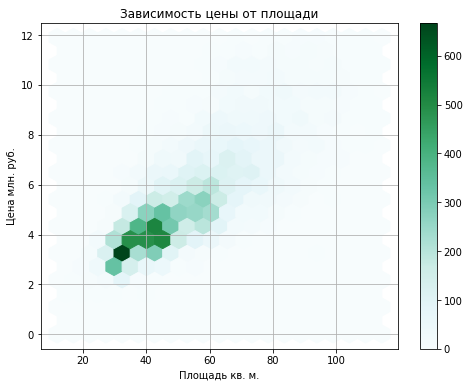

In [25]:


kc2 = round(good_df['last_price_1kk'].corr(good_df['total_area']),2)

df_nearest_centers.plot(y="last_price_1kk", x="total_area",kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True)#kind='scatter',alpha=0.03)
plt.title('Зависимость цены от площади')
plt.ylabel('Цена млн. руб.')
plt.xlabel('Площадь кв. м.')

print('Коофецент корреляции равен ' + str(kc2))

###   Вывод

- есть зависимость цены от количество комнат, чем больше комнат тем выше цена, но это справедливо для квартир до 3 комнат, для 4, 5 и 6 комннат зависимость нивилируется, квартиры в среднем продаются по одной цене, связанно с отсутствием спроса, очень маленькое количество продаж таких квартир 
- самая сильная зависмость у цены и площади(высокий коофецент корреляции 0,68)
- в среднем квартиры на первом и последнем этажах продаются дешевле относительно других
- взаимосвязи цены и продажи по дням недели не наблюдается
- квартиры выставленные в апреле имееют цены чуть выше среднего чем остальные месяцы, в июне самые низкие цены, в мае самый низкий спрос на квартиры, в феврале самый высокий
- с 2016 по 2019 год цена на жилье растет, цены в 2014 самые высокие(делать какие либо выводы про  2014 год считаю не целесообразным из-за маленькой выборки 7 объявлений)
- расстояние от центра влият на цену, но слабо и обратно пропорционально

В итоге:

- средняя жилая недвижимость это 2-х комнатаная квартира, 52 кв. метра, высота потолков 2,65 метра, продающаяся за 4,65 млн. рублей, за 95 дней
- аномальная жилая недвижимость имеет более 6 комнат, более 114,75 кв. метра площадь, высотой потолков меньше 2,25 и больше 3,05 продающаяся свыше 11,9 млн рублей в срок от 430 дней



### Найдем топ 10 населенных пунктов по количеству объявлений

In [26]:
df_big10 = df.pivot_table(index = 'locality_name', aggfunc={'count', 'median'})['price_sqrm'].sort_values(by = 'count', ascending = False)
# таблица сгрупированная по названиям населенных пунктов, с количеством и средней ценой за квадратный метр

print(df.pivot_table(index = 'locality_name', aggfunc={'count', 'median'})['price_sqrm'].sort_values(by = 'median').head(1)) #  населенный пункт с самым дешевым жильем
print(df.pivot_table(index = 'locality_name', aggfunc={'count', 'median'})['price_sqrm'].sort_values(by = 'median', ascending = False).head(1))  # населенный пункт с самым дорогим жильем

df_big10.head(10) # топ 10 населенных пунктов с самым большим числом объявлений


               count  median
locality_name               
Старополье         3   0.011
                 count    median
locality_name                   
Санкт-Петербург  15721  0.104762


,count,median
locality_name,,
Санкт-Петербург,15721,0.104762
Мурино,590,0.086176
Кудрово,472,0.095675
Шушары,440,0.076876
Всеволожск,398,0.065789
Пушкин,369,0.100000
Колпино,338,0.074724
Парголово,327,0.091643
Гатчина,307,0.067797


### Вывод
Самое дорогое жилье и самое большое количество объявлений в Санкт-Петербурге, самое дешёвое жилье в Старополье

## Исследуем область центр Санкт-Петербурга
 ### Найдем радиус центра Санкт-Петербурга

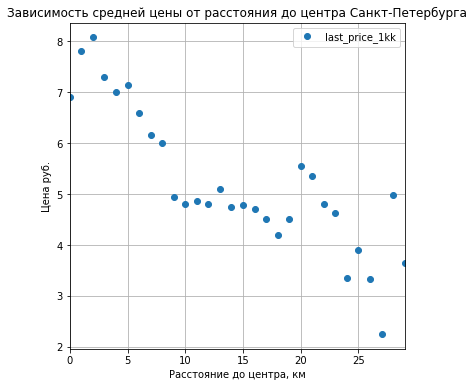

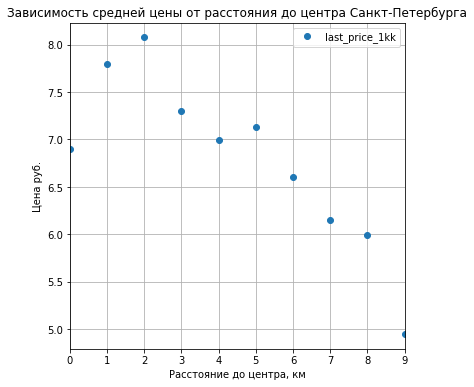

In [27]:
df_nearest_centers['city_centers_km'] = round(df_nearest_centers['cityCenters_nearest'] /  1000, 0) # добавим столбец, в км
df_nearest_centers['city_centers_km'] = df_nearest_centers['city_centers_km'].astype('int', errors='ignore')# округлим до целых значений
spb_data = df_nearest_centers.query('locality_name == "Санкт-Петербург"')# создадим таблицу только по Санкт_Петербургу



spb_centers_nearest = spb_data.pivot_table(index='city_centers_km', values=['last_price_1kk','price_sqrm'], aggfunc='median').reset_index()
spb_centers_nearest.plot(x='city_centers_km',y='last_price_1kk', style='o', grid=True, figsize=(6,6))
# построим график для выявления центра, там где будет резкий обрыв, там заканчиваетс яцентр

plt.title('Зависимость средней цены от расстояния до центра Санкт-Петербурга')
plt.ylabel('Цена руб.')
plt.xlabel('Расстояние до центра, км')

spb_centers_nearest.query('city_centers_km < 10').plot(x='city_centers_km',y='last_price_1kk', style='o', grid=True, figsize=(6,6))
# для приближенного просмотра 
plt.title('Зависимость средней цены от расстояния до центра Санкт-Петербурга')
plt.ylabel('Цена руб.')
plt.xlabel('Расстояние до центра, км')
spb_center = spb_data.query('city_centers_km <= 8 ') # таблица с центром Санкт-Петербурга

### Вывод
Центр Санкт-Петербурга это область с радиусом в 8км

### Изучаем параметры центра Питера

In [28]:
spb_center.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,1800.0,9.664444e+00,5.629141e+00,0.000000e+00,6.000000e+00,9.000000e+00,1.400000e+01,3.200000e+01
last_price,1800.0,6.951051e+06,2.208181e+06,1.600000e+06,5.285000e+06,6.750000e+06,8.500000e+06,1.190000e+07
total_area,1800.0,6.038864e+01,2.012197e+01,1.200000e+01,4.450000e+01,5.859500e+01,7.442500e+01,1.142000e+02
rooms,1800.0,2.135000e+00,9.174350e-01,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
ceiling_height,1800.0,2.757744e+00,1.854841e-01,2.400000e+00,2.550000e+00,2.750000e+00,3.000000e+00,3.050000e+00
floors_total,1798.0,8.023359e+00,4.696641e+00,2.000000e+00,5.000000e+00,6.000000e+00,1.000000e+01,2.800000e+01
living_area,1664.0,3.499162e+01,1.479041e+01,2.000000e+00,2.230000e+01,3.300000e+01,4.490000e+01,8.700000e+01
floor,1800.0,4.430556e+00,3.310445e+00,1.000000e+00,2.000000e+00,4.000000e+00,5.000000e+00,2.300000e+01
kitchen_area,1626.0,1.050176e+01,4.619040e+00,0.000000e+00,7.600000e+00,9.500000e+00,1.220000e+01,4.100000e+01
balcony,1800.0,3.494444e-01,7.482421e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00


                total_area  last_price_1kk     rooms  ceiling_height
total_area        1.000000        0.717045  0.801774        0.208495
last_price_1kk    0.717045        1.000000  0.460999        0.174095
rooms             0.801774        0.460999  1.000000        0.155938
ceiling_height    0.208495        0.174095  0.155938        1.000000


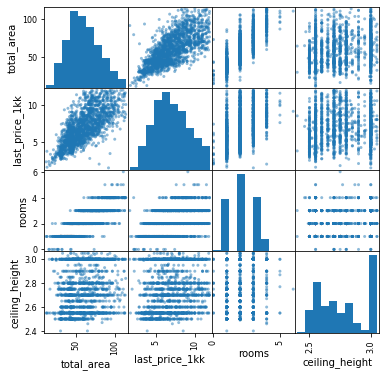

In [29]:
new_spb_center = spb_center.loc[:,['total_area','last_price_1kk','rooms','ceiling_height']]
pd.plotting.scatter_matrix(new_spb_center, figsize=(6,6))
print(new_spb_center.corr())  

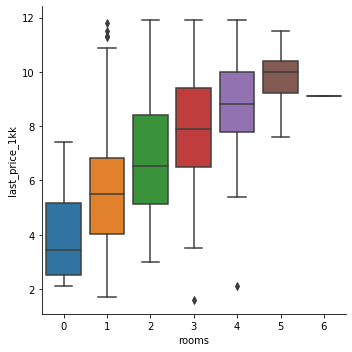

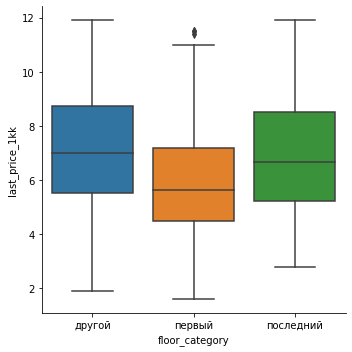

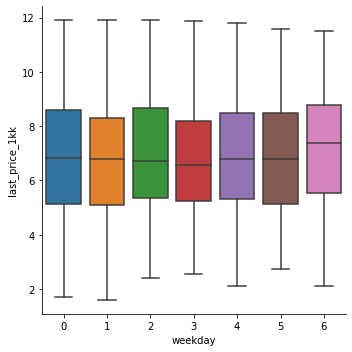

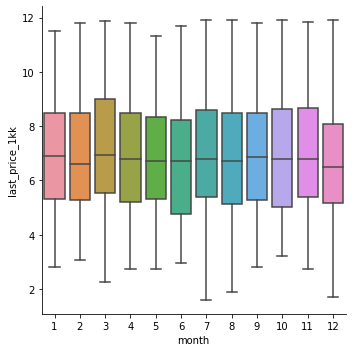

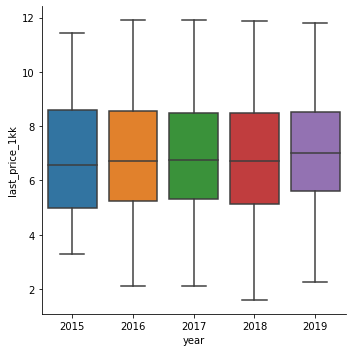

In [30]:
for column in ['rooms', 'floor_category', 'weekday', 'month', 'year']:
    sns.catplot(x=column, y="last_price_1kk", kind="box", data=spb_center)

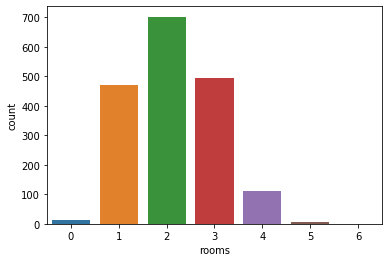

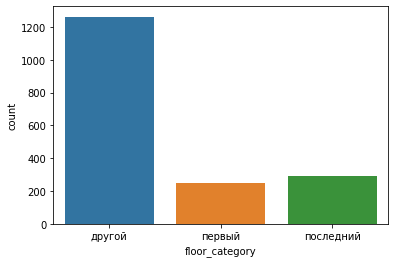

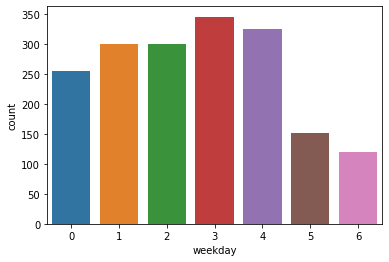

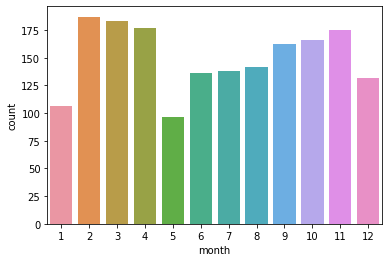

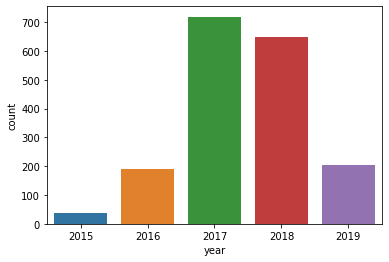

In [31]:
df_cat_center = spb_center.loc[:,['rooms', 'floor_category', 'weekday', 'month', 'year']]

for column in df_cat:
    sns.countplot(x=column,data=df_cat_center)
    plt.show()

### Вывод
- В центре относительно области наблюдается выше зависимость цены от количества комнат, это касается и многокомнатных квартир 4х  и 5ти комнат
- первый этаж также как и в не центра стоит дешевле относительно других этажей, но последний этаж стоит дороже, возможно связанно с тем что в Питере в центре нет многоэтажных домов, и в Питере на последнем этаже открывается прекрасный вид, или есть выход на крышу
- в центре квартиры продаваемые в воскресенье стоят дороже, но количество продаж по воскресеньям меньше относительно других дней недели
- март, июль, сентябрь имеют среднюю цену продажи выше относительно других месяцев в зоне центра, февраль и декабрь средняя цена ниже
- в центре Санкт-Питербурга наблюдается рост цен из года в год
- В центре наблюдается слабая корреляция высоты потолков с ценой
- Самая высокие цены в радиусе 2км в центре, отдаляясь от центра цена падает

#  Шаг 5 Общий вывод

### Выводы и рекомендации по открытию и предобработке данных
- Данные заполнены достаточно "грязно", об этом свидетельствует огромное количество пропусков
- в предобработке было выполненно:
  - заполнение пропусков в "балконах"
  - название населенных пунктов приведены к имени собственному
  - заполнение пропусков в "высоте потолков" и исправленны некоторые ошибки ввода(такие как 27 метровые потолки)
  - замена типов данных для облегчения фрейма
  - замена типа данных в "сроке публикации" на дататайм
Рекомендации:
- ограничить выбор пользовательского ввода данных, создать опциональный выбор, при нестандартных значениях ввести параметр "Другое/Свое" с возможностью описать параметр 
- сделать невозможным не заполнение таких параметров как: "Апартаменты", "Количество этажей", "Жилая площадь",  "Площадь кухни"
- в таблице нет данных о близости к метро, близости въезда на КАД или ЗСД(актуально для Питера и близ лежащих населенных пунктов, рекомендуется добавить

### Выводы после исследовательского анализа данных

- есть зависимость цены от количество комнат, чем больше комнат тем выше цена, но это справедливо для квартир до 3 комнат, для 4, 5 и 6 комннат зависимость нивилируется, квартиры в среднем продаются по одной цене, связанно с отсутствием спроса, очень маленькое количество продаж таких квартир 
- самая сильная зависмость у цены и площади(высокий коофецент корреляции 0,68)
- в среднем квартиры на первом и последнем этажах продаются дешевле относительно других
- взаимосвязи цены и продажи по дням недели не наблюдается
- квартиры выставленные в апреле имееют цены выше среднего чем в остальные месяцы, в июне самые низкие цены, в мае самый низкий спрос на квартиры, в феврале самый высокий
- с 2016 по 2019 год цена на жилье растет, цены в 2014 самые высокие(делать какие либо выводы про  2014 год считаю не целесообразным из-за маленькой выборки 7 объявлений)
- расстояние от центра влият на цену, но слабо и обратно пропорционально, коофицент корреляции -0,31
- средняя жилая недвижимость это 2-х комнатаная квартира, 52 кв. метра, высота потолков 2,65 метра, продающаяся за 4,65 млн. рублей, за 95 дней
- аномальная жилая недвижимость имеет более 6 комнат, более 114,75 кв. метра площадь, высотой потолков меньше 2,25 и больше 3,05 продающаяся свыше 11,9 млн рублей в срок от 430 дней
- Самое дорогое жилье и самое большое количество объявлений в Санкт-Петербурге

### Выводы после исследовательского анализа данных в центре Санкт-Петербурга

- Центром в Санкт-Петербурге является зона радиусом в 8км
- В центре относительно области наблюдается выше зависимость цены от количества комнат, это касается и многокомнатных квартир 4х  и 5ти комнат, спорс на многокомнатные квартиры выше относительно других населенных пунктов
- первый этаж также как и в не центра стоит дешевле относительно других этажей, но последний этаж стоит дороже, возможно связанно с тем что в Питере в центре нет многоэтажных домов, и в Питере на последнем этаже открывается прекрасный вид, или есть выход на крышу(Питерская романтика)
- в центре, квартиры продаваемые в воскресенье стоят дороже, но количество продаж по воскресеньям меньше относительно других дней недели
- март, июль, сентябрь имеют среднюю цену продажи выше относительно других месяцев в зоне центра, февраль и декабрь средняя цена ниже
- в центре Санкт-Питербурга наблюдается рост цен из года в год
- В центре наблюдается слабая корреляция высоты потолков с ценой
- Самая высокие цены в радиусе 2км в центре, отдаляясь от центра цена падает






   